In [4]:
!pip install tensorflow_datasets

     |████████████████████████████████| 4.3 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 51 kB 5.9 MB/s  eta 0:00:01
     |████████████████████████████████| 211 kB 13.1 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=9fbdbe58a61d5f598586ab18533ceca309b228da08cfea294ee6ce706c76381a
  Stored in directory: /home/h3r0/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [2]:
import requests
import os
# if 'TPU_DRIVER_MODE' not in globals():
#   url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
#   resp = requests.post(url)
#   TPU_DRIVER_MODE = 1
# The following is required to use TPU Driver as JAX's backend.
import os
from jax.config import config
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
# print(config.FLAGS.jax_backend_target)

In [5]:
import os
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn

import tensorflow as tf
import tensorflow_datasets as tfds

def shard(xs):
    return jax.tree_map(
        lambda x: x.reshape((jax.device_count(), -1) + x.shape[1:]), xs)

class Generator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, z):
        x = nn.ConvTranspose(features=64*8, kernel_size=(4, 4),
                             strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*4, kernel_size=(4, 4),
                             strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*2, kernel_size=(4, 4),
                             strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64, kernel_size=(
            4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=1, kernel_size=(
            4, 4), strides=(1, 1), padding='SAME', use_bias=False)(x)
        return jnp.tanh(x)


class Discriminator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=64, kernel_size=(
            4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*2, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*4, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*8, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=1, kernel_size=(
            1, 1), strides=(4, 4), padding='VALID', use_bias=False)(x)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x


@jax.vmap
def bce_logits_loss(logit, label):
    return jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(-jnp.abs(logit)))


def loss_g(params_g, params_d, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply(
        {'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    fake_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    return jnp.mean(bce_logits_loss(fake_logits, real_labels)), (variables_g, variables_d)


def loss_d(params_d, params_g, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply(
        {'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    real_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, batch, mutable=['batch_stats'])
    fake_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = bce_logits_loss(real_logits, real_labels)

    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = bce_logits_loss(fake_logits, fake_labels)

    return jnp.mean(real_loss + fake_loss), (variables_g, variables_d)


@partial(jax.pmap, axis_name='batch')
def train_step(rng, variables_g, variables_d, optimizer_g, optimizer_d, batch):
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    (g_loss, (variables_g, variables_d)), grad_g = jax.value_and_grad(loss_g, has_aux=True)(
        optimizer_g.target, optimizer_d.target, batch, rng_g, variables_g, variables_d)
    g_loss = jax.lax.pmean(g_loss, axis_name='batch')
    grad_g = jax.lax.pmean(grad_g, axis_name='batch')

    optimizer_g = optimizer_g.apply_gradient(grad_g)

    (d_loss, (variables_g, variables_d)), grad_d = jax.value_and_grad(loss_d, has_aux=True)(
        optimizer_d.target, optimizer_g.target, batch, rng_d, variables_g, variables_d)

    d_loss = jax.lax.pmean(d_loss, axis_name='batch')
    grad_d = jax.lax.pmean(grad_d, axis_name='batch')

    optimizer_d = optimizer_d.apply_gradient(grad_d)

    return rng, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss


def make_dataset(batch_size, seed=1):
    mnist = tfds.load("mnist")

    def _preprocess(sample):
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        image = tf.image.resize(image, (32, 32))
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))


def main():
    dataset = make_dataset(batch_size=256)

    rng = jax.random.PRNGKey(42)
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    init_batch_g = jnp.ones((1, 1, 1, 100), jnp.float32)
    variables_g = Generator(training=True).init(rng_g, init_batch_g)

    init_batch_d = jnp.ones((1, 32, 32, 1), jnp.float32)
    variables_d = Discriminator(training=True).init(rng_d, init_batch_d)

    optimizer_g = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_g["params"])
    optimizer_g = flax.jax_utils.replicate(optimizer_g)

    optimizer_d = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_d["params"])
    optimizer_d = flax.jax_utils.replicate(optimizer_d)

    variables_g = flax.jax_utils.replicate(variables_g)
    variables_d = flax.jax_utils.replicate(variables_d)

    rngs = jax.random.split(rng, num=jax.local_device_count())

    g_losses = []
    d_losses = []

    for i in tqdm(range(2000)):
        img_a = shard(next(dataset))

        rngs, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss = train_step(
            rngs, variables_g, variables_d, optimizer_g, optimizer_d, img_a)

        if i % 10 == 0:
            g_losses.append(float(jnp.mean(g_loss)))
            d_losses.append(float(jnp.mean(d_loss)))

            if i % 500 == 0:
                rng, rng_sample = jax.random.split(rng)
                z = jax.random.normal(rng_sample, shape=(1, 1, 1, 100))

                temp_params_g = flax.jax_utils.unreplicate(
                    optimizer_g.target)
                temp_variables_g = flax.jax_utils.unreplicate(variables_g)

                samples = Generator(training=False).apply(
                    {'params': temp_params_g, 'batch_stats': temp_variables_g['batch_stats']}, z, mutable=False)

                img = jnp.reshape((samples + 1) / 2, [32, 32])
                plt.imshow(img, cmap='gray')
                plt.show()
    return g_losses, d_losses

In [6]:
print(jax.devices())

[CpuDevice(id=0)]


2022-07-07 19:22:26.846455: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2022-07-07 19:22:32.857811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 19:22:32.857963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-07 19:22:32.858070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-07 19:22:32.858175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-07-07 19:22:32.858276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

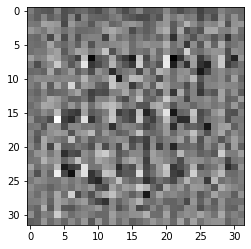

  1%|▌                                             | 26/2000 [24:44<32:42:16, 59.64s/it]

In [ ]:
g_losses, d_losses = main()

In [ ]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()
plt.show()